#Installing and Importing Libraries




In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6ef46521b3a4294e2ebf65991e565423679ff0df046081bc0ff839475f2d8658
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch

# NLP processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_recall_fscore_support,
    roc_curve, auc, precision_recall_curve
)

# Transformers
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback, IntervalStrategy
)
from transformers.trainer_callback import TrainerCallback


# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# Convert text to lowercase during loading
fake_df['text'] = fake_df['text'].str.lower()
real_df['text'] = real_df['text'].str.lower()

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017"


In [ ]:
#Check total data
fake_df.shape

(23481, 4)

In [ ]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington (reuters) - the special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsNews,"December 29, 2017"


In [ ]:
real_df.shape

(21417, 4)

#Data Preprocessing



In [ ]:
#Adding labels to the datasets

fake_df['label'] = 1  # Fake news
real_df['label'] = 0  # Real news

In [ ]:
#Combining the datasets as one

data = pd.concat([fake_df, real_df], ignore_index=True)

data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",1


In [ ]:
#Total Data
data.shape

(44898, 5)

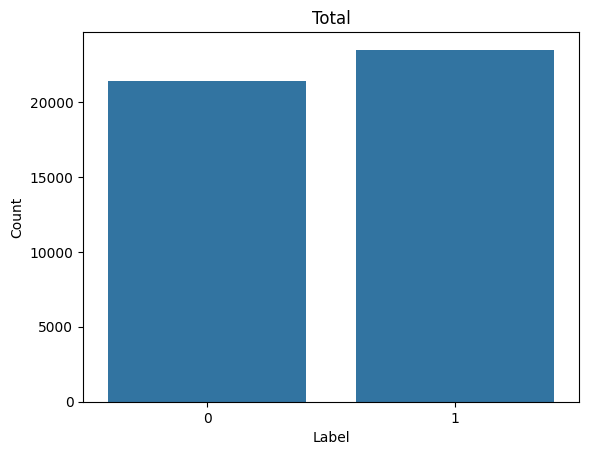

In [ ]:
sns.countplot(x='label', data=data)
plt.title('Total')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
# Shuffling data
df = data.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis=1, inplace=True)

In [ ]:
df

,title,text,subject,date,label
0,Trump administration backs looser Obamacare wa...,new york (reuters) - the trump administration ...,politicsNews,"March 13, 2017",0
1,"Germany softens stance on Turkish arms sales, ...",ankara/berlin (reuters) - chancellor angela me...,worldnews,"September 12, 2017",0
2,New York governor calls for amending state con...,new york (reuters) - new york governor andrew ...,politicsNews,"January 30, 2017",0
3,THE HEARTLESS MARXIST: What Bernie Sanders Did...,who kicks homeless people out onto the streets...,left-news,"Jan 19, 2016",1
4,Italy's Northern League criticizes magistrates...,rome (reuters) - the leader of one of italy s ...,worldnews,"September 14, 2017",0
...,...,...,...,...,...
44893,Pakistan's top diplomat pushes back on U.S. cl...,washington (reuters) - pakistan s foreign mini...,worldnews,"October 5, 2017",0
44894,North Korean threat highlights NATO missile sh...,brussels (reuters) - nato has joined world pow...,worldnews,"September 12, 2017",0
44895,Trump Is LITERALLY Polling At 0% With Black P...,donald trump s recent african-american outrea...,News,"August 30, 2016",1
44896,Trump says he believes block-grant healthcare ...,washington (reuters) - u.s. president donald t...,politicsNews,"October 17, 2017",0


In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Required for lemmatization

def enhanced_text_cleaning(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase first for consistency
    text = text.lower()

    # Handle social media and news agency references
    # Remove "pic twitter com" and anything that follows it on the same word
    text = re.sub(r'pic\.?twitter\.?com\S*', ' ', text)
    text = re.sub(r'twitter\.com\S*', ' ', text)

    # Remove references to common news/media sources
    news_agencies = ['reuters', 'ap', 'afp', 'getty image', 'getty images', 'flickr',
                     'instagram', 'facebook', 'youtube', 'washington post']
    for agency in news_agencies:
        text = re.sub(rf'\b{agency}\b.*?(?=\s|$)', ' ', text)

    # Remove content after "via" (common citation pattern)
    text = re.sub(r'\svia \s.*?(?=\.|$)', ' ', text)

    # Remove URL fragments that might be broken incorrectly
    text = re.sub(r'\w+\.com\S*', ' ', text)
    text = re.sub(r'\w+\.co\S*', ' ', text)
    text = re.sub(r'\w+\.org\S*', ' ', text)

    # Remove specific common patterns in your dataset
    text = re.sub(r'eoklflkiqy', ' ', text)
    text = re.sub(r'eugwd', ' ', text)

    # Remove standard social media indicators
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', ' ', text)  # Remove RT
    text = re.sub(r'https?://\S+', ' ', text)  # Remove URLs
    text = re.sub(r'http\S+', ' ', text)  # Remove other links

    # Identify and separate joined words (common in social media content)
    # Look for patterns like "anothernight" -> "another night"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Split camelCase


    # Remove month+year patterns
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{4}\b', ' ', text)

    # Enhanced spacing around punctuation
    text = re.sub(r'([.,!?:;\(\)\[\]{}"\'-])', r' \1 ', text)

    # Fix additional word joining issues
    text = re.sub(r'(\w)(\d)', r'\1 \2', text)  # Split words and numbers
    text = re.sub(r'(\d)(\w)', r'\1 \2', text)  # Split numbers and words

    # Replace remaining non-alphanumeric with spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Normalize spaces and remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Add more specific words to remove beyond standard stopwords
    custom_stopwords = ['image', 'photo', 'picture', 'pic', 'reuters', 'said', 'say', 'says',
                        'via', 'getty', 'afp', 'jpg', 'jpeg', 'png', 'video', 'screenshots', 'screenshot', 'gateway pundit']

    # Combine with standard stopwords
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = text.split()

    # Filter words by length and stopword status
    text = ' '.join([word for word in words if word not in stop_words and len(word) > 2])

    return text.strip()

def apply_stemming(text):
    stemmer = PorterStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def apply_lemmatization(text):
    """Apply lemmatization for more natural word forms"""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def check_token_length(text, min_words=10):
    """
    Check if the text has enough tokens after preprocessing
    If not, return the original text with stopwords preserved
    """
    words = text.split()
    if len(words) < min_words:
        # If too short, keep stopwords but maintain other cleaning
        text_with_stopwords = enhanced_text_cleaning(text)
        words_with_stopwords = text_with_stopwords.split()
        return ' '.join([word for word in words_with_stopwords if len(word) > 2])
    return text

def improved_preprocess_text(text, use_stemming=False, use_lemmatization=True, min_token_length=10):
    """
    Complete preprocessing pipeline with enhanced social media pattern removal
    """
    # Basic cleaning with enhanced spacing and social media pattern removal
    text = enhanced_text_cleaning(text)

    # Apply stemming or lemmatization (not both)
    if use_lemmatization:
        text = apply_lemmatization(text)
    elif use_stemming:
        text = apply_stemming(text)

    # Verify the text isn't too short after processing
    text = check_token_length(text, min_token_length)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


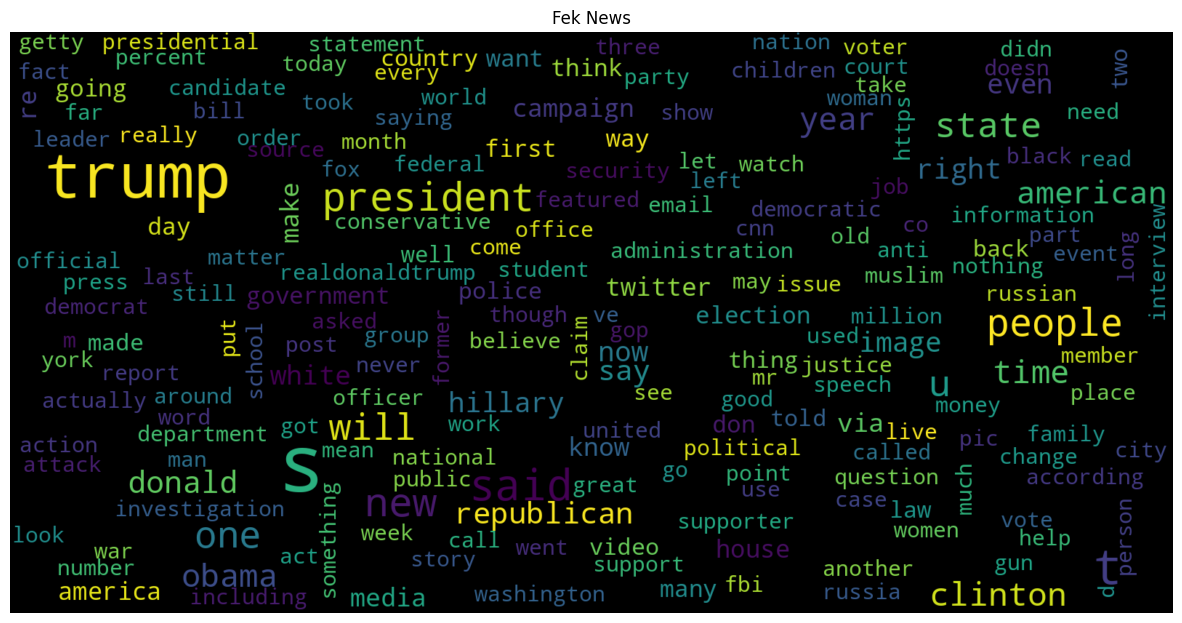

In [ ]:
#Visualising WordCloud (to get a visual look of the most used words)


consolidated = ' '.join(
    word for word in df['text'][df['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title('Fek News')
plt.show()

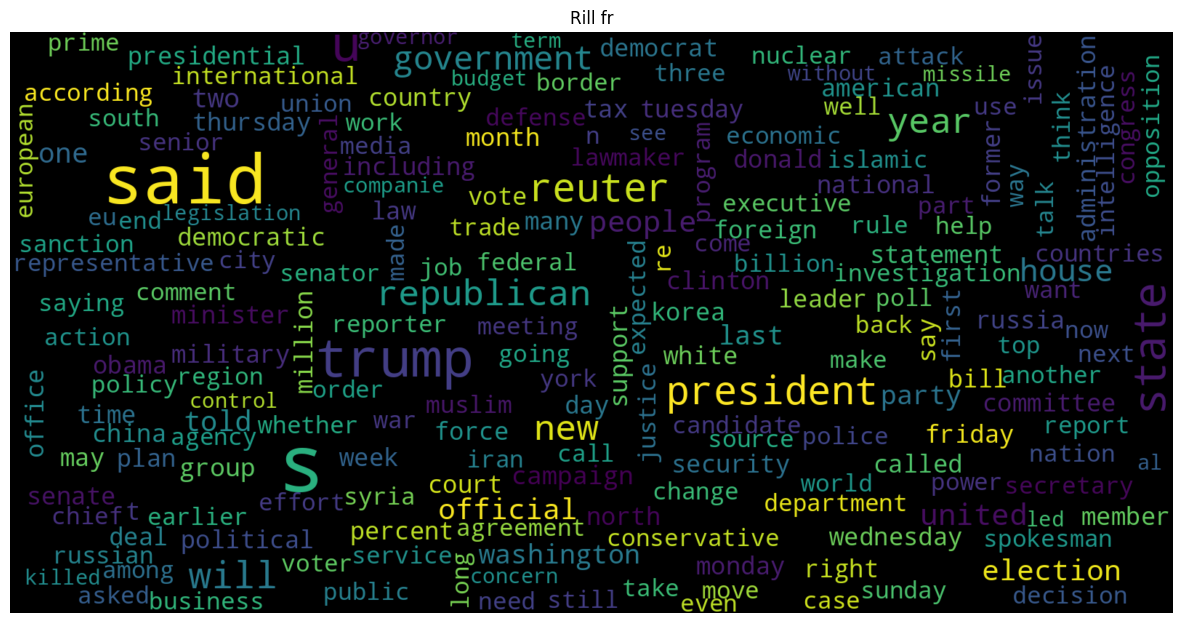

In [ ]:
#Real News

consolidated = ' '.join(
    word for word in df['text'][df['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title('Rill fr')
plt.show()

In [ ]:
# Train Test Split, 80 Training : 20 Testing
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=32)

# Splits the Testing into 50:50 (10% val, 10% test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Apply preprocessing
print("Preprocessing training data...")
train_df['text'] = train_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                       use_stemming=False,
                                                       use_lemmatization=True,
                                                       min_token_length=10))

print("Preprocessing validation data...")
val_df['text'] = val_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                     use_stemming=False,
                                                     use_lemmatization=True,
                                                     min_token_length=10))

print("Preprocessing test data...")
test_df['text'] = test_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                   use_stemming=False,
                                                   use_lemmatization=True,
                                                   min_token_length=10))

# Extract text and labels
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...


NameError: name 'analyze_token_distribution' is not defined

In [ ]:
val_texts

['republican democrat battle dozen state hold election governor tuesday many race could close call drawing national attention debate transgender right republican governor pat mccrory seeking second term roy cooper democrat state attorney general since poll show cooper modest lead state also competitive race president senate one year closest gubernatorial race poll put republican former navy seal eric greitens dead heat democrat chris koster state attorney general bidding succeed governor jay nixon democrat served maximum two term office indiana governor mike penny initially sought election withdrew gubernatorial race july campaign republican presidential nominee donald trump running mate lieutenant governor eric holcomb republican stepped penny compete democrat john gregg former state lawmaker gregg narrowly lead holcomb according poll democratic businessman jim justice lead republican state senate president bill cole poll though data sparse democratic governor earl ray tomblin barred 

In [ ]:
# Check class imbalance in full dataset
print("Class distribution in full dataset:")
print(df['label'].value_counts())
print(f"Percentage of fake news: {df['label'].mean()*100:.2f}%")
print(f"Percentage of real news: {(1-df['label'].mean())*100:.2f}%")

# Check class imbalance in splits
print("\nClass distribution in train set:")
print(pd.Series(train_labels).value_counts())
print(f"Percentage of fake news in train: {np.mean(train_labels)*100:.2f}%")

print("\nClass distribution in validation set:")
print(pd.Series(val_labels).value_counts())
print(f"Percentage of fake news in val: {np.mean(val_labels)*100:.2f}%")

print("\nClass distribution in test set:")
print(pd.Series(test_labels).value_counts())
print(f"Percentage of fake news in test: {np.mean(test_labels)*100:.2f}%")

Class distribution in full dataset:
label
1    23481
0    21417
Name: count, dtype: int64
Percentage of fake news: 52.30%
Percentage of real news: 47.70%

Class distribution in train set:
1    18771
0    17147
Name: count, dtype: int64
Percentage of fake news in train: 52.26%

Class distribution in validation set:
1    2366
0    2124
Name: count, dtype: int64
Percentage of fake news in val: 52.69%

Class distribution in test set:
1    2344
0    2146
Name: count, dtype: int64
Percentage of fake news in test: 52.20%


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_attention_mask=True
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_attention_mask=True
)
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_attention_mask=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

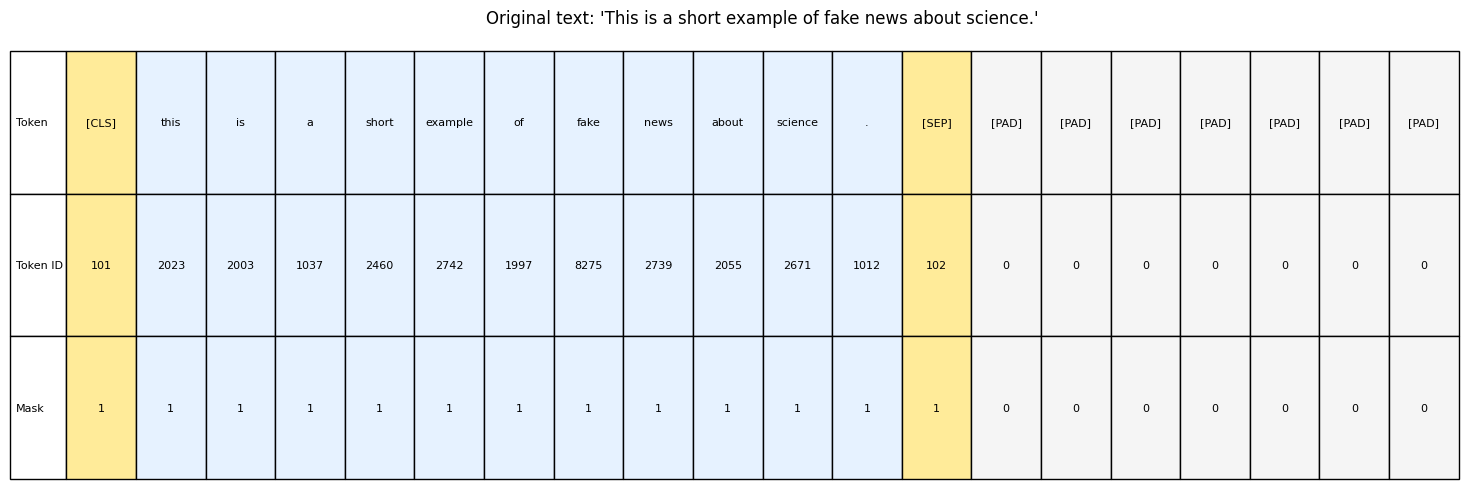

Total tokens: 20
Tokens with attention (non-padding): 13
Truncated: No


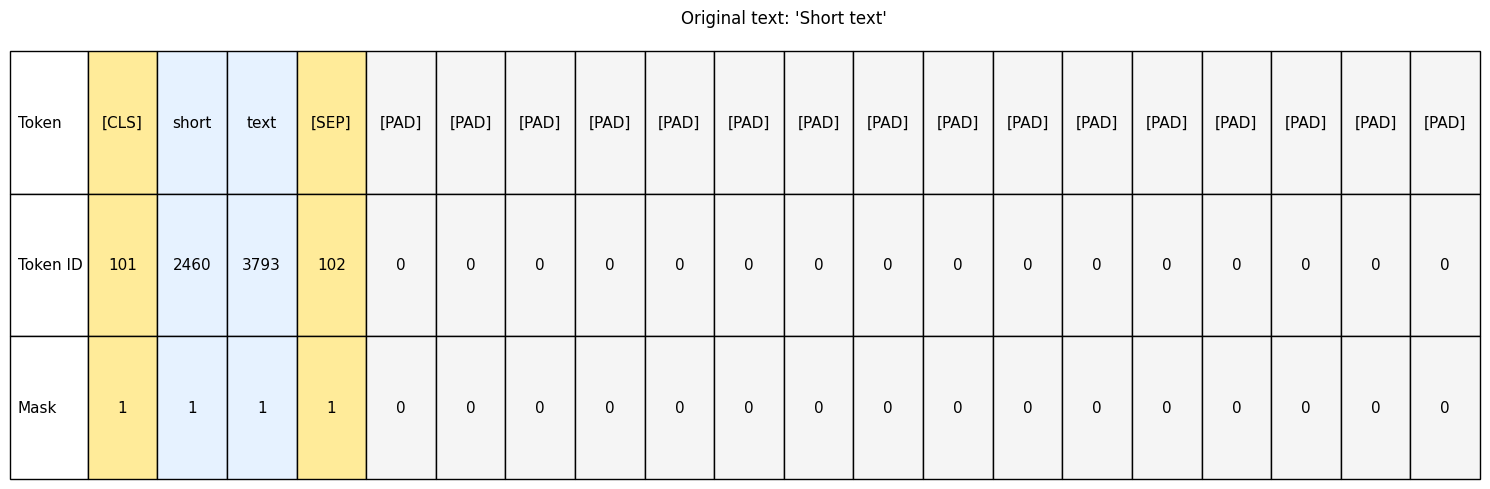

Total tokens: 20
Tokens with attention (non-padding): 4
Truncated: No


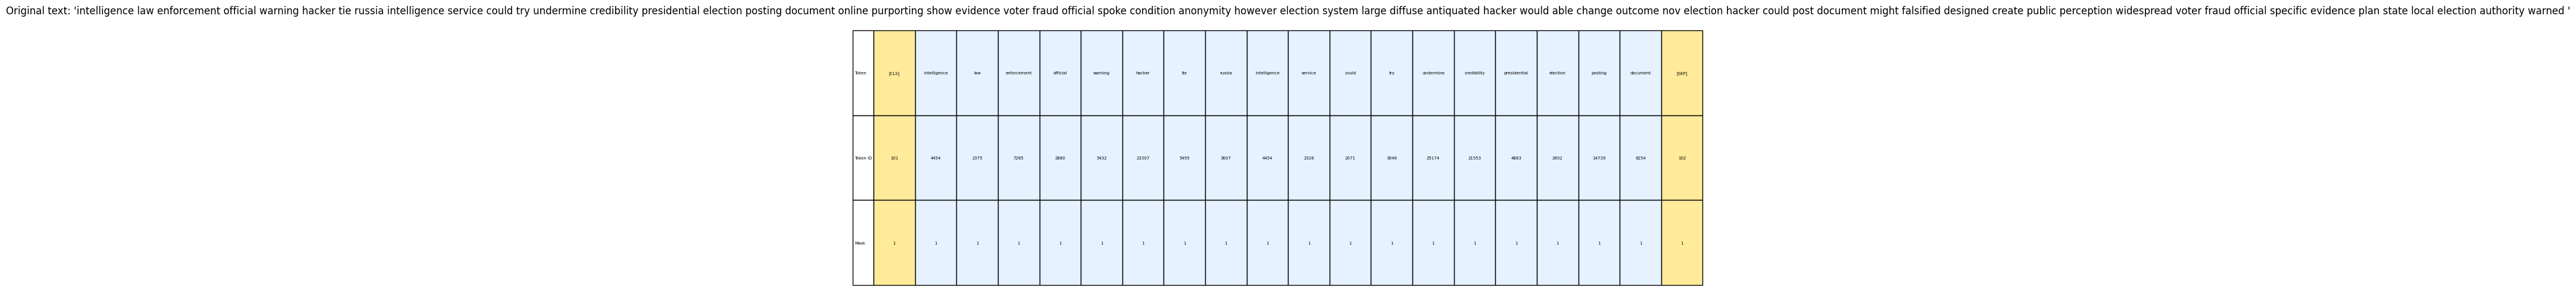

Total tokens: 20
Tokens with attention (non-padding): 20
Truncated: Yes
Percentage of text that fits in 20 tokens: 24.3%


In [ ]:
def visualize_tokenization(text, tokenizer, max_length=20):
    """
    Visualize how the tokenizer works on a sample text.
    Shows tokens, token IDs, and attention mask.
    """
    # Tokenize with a smaller max_length for display purposes
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_attention_mask=True,
        return_tensors='np'
    )

    # Get tokens (decode each token ID individually)
    input_ids = encoding['input_ids'][0]
    tokens = [tokenizer.decode([id]).strip() for id in input_ids]
    attention_mask = encoding['attention_mask'][0]

    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 5))

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Title with original text
    plt.title(f"Original text: '{text}'", fontsize=12, pad=20)

    # Create table for visualization
    table_data = [tokens, input_ids, attention_mask]
    colors = []

    # Color coding based on token type and attention mask
    for i in range(len(tokens)):
        if attention_mask[i] == 0:
            colors.append('#f5f5f5')  # Light gray for padding
        elif tokens[i] in ['[CLS]', '[SEP]']:
            colors.append('#ffeb99')  # Light yellow for special tokens
        else:
            colors.append('#e6f2ff')  # Light blue for normal tokens

    # Create table
    table = plt.table(
        cellText=table_data,
        rowLabels=['Token', 'Token ID', 'Mask'],
        cellColours=[colors] * 3,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )

    # Style the table
    table.scale(1, 1.5)
    table.set_fontsize(11)

    plt.tight_layout()
    plt.show()

    # Print additional info
    print(f"Total tokens: {len(tokens)}")
    print(f"Tokens with attention (non-padding): {sum(attention_mask)}")
    print(f"Truncated: {'Yes' if len(tokenizer.encode(text)) > max_length else 'No'}")

    # Show the percentage of the text that fits in the token limit
    full_tokens = tokenizer.encode(text)
    if len(full_tokens) > max_length:
        print(f"Percentage of text that fits in {max_length} tokens: {(max_length-2)/len(full_tokens)*100:.1f}%")
        # -2 accounts for [CLS] and [SEP] tokens

# Visualize short example
visualize_tokenization("This is a short example of fake news about science.", tokenizer)

# Visualize example with padding
visualize_tokenization("Short text", tokenizer)

# Visualize example with truncation (using a longer text from the dataset)
sample_long_text = test_texts[0][:500]  # Take first 500 chars of a test example
visualize_tokenization(sample_long_text, tokenizer)

In [ ]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    max_length=512
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none",
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=42,
    data_seed=42,
    dataloader_drop_last=False,
    fp16=True,
    gradient_accumulation_steps=1,
    label_smoothing_factor=0.1
)

# Modified model with improved dropout configuration
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    dropout=0.2  # DistilBERT uses a single dropout parameter
)

Class weights: {0: np.float64(1.0473552224878988), 1: np.float64(0.956741782536892)}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)


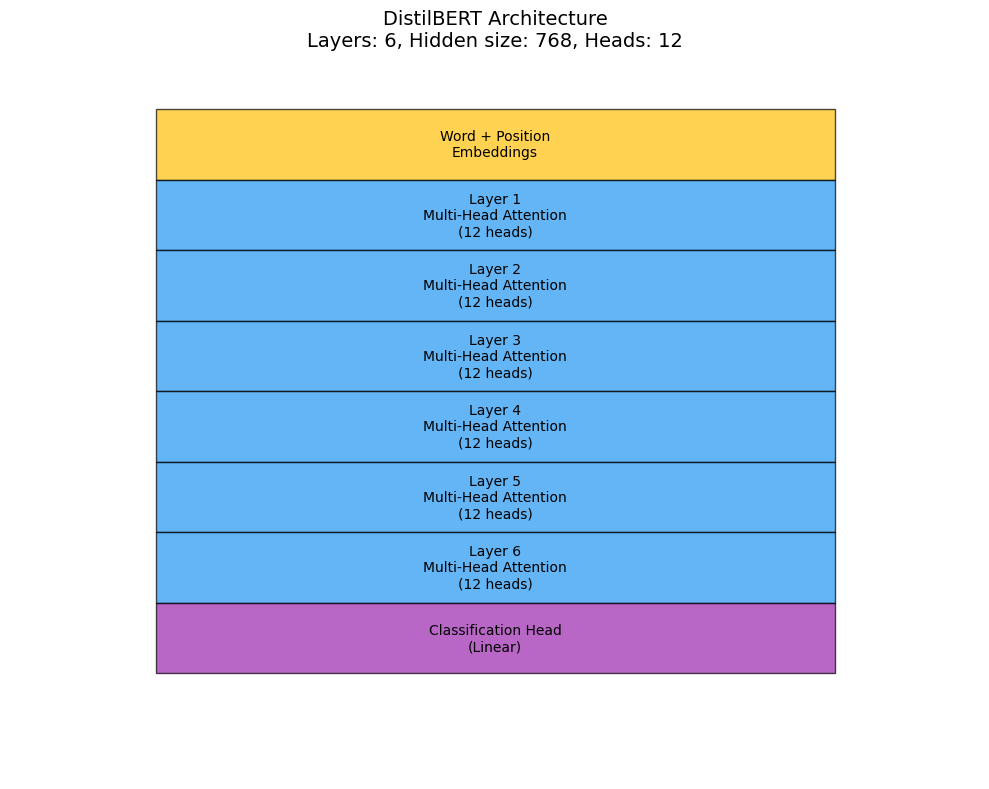

Total parameters: 66,955,010
Trainable parameters: 66,955,010
Model hidden size: 768
Number of attention layers: 6
Number of attention heads: 12


In [ ]:
def visualize_bert_architecture(model, title="DistilBERT Architecture"):
    """Create a visualization of the BERT model architecture"""
    # Count layers
    num_attention_layers = model.config.num_hidden_layers
    hidden_size = model.config.hidden_size
    num_attention_heads = model.config.num_attention_heads

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')

    # Colors
    colors = {
        'embeddings': '#FFC107',
        'attention': '#2196F3',
        'intermediate': '#4CAF50',
        'output': '#F44336',
        'classifier': '#9C27B0',
        'text': '#000000'
    }

    # Spacing parameters
    y_start = 0.9
    y_end = 0.1
    layer_height = (y_start - y_end) / (num_attention_layers + 2)  # +2 for embedding and classifier
    box_width = 0.7

    # Draw embedding layer
    draw_box(ax, 0.5, y_start, box_width, layer_height,
             'Word + Position\nEmbeddings', colors['embeddings'])

    # Draw attention layers
    y = y_start - layer_height
    for i in range(num_attention_layers):
        # Attention box
        draw_box(ax, 0.5, y, box_width, layer_height,
                 f"Layer {i+1}\nMulti-Head Attention\n({num_attention_heads} heads)",
                 colors['attention'])
        y -= layer_height

    # Draw classifier
    draw_box(ax, 0.5, y, box_width, layer_height,
             'Classification Head\n(Linear)', colors['classifier'])

    # Add title with info
    plt.title(f"{title}\nLayers: {num_attention_layers}, Hidden size: {hidden_size}, Heads: {num_attention_heads}",
              fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

def draw_box(ax, x, y, width, height, text, color, alpha=0.7):
    """Helper function to draw a box with text"""
    rect = plt.Rectangle((x - width/2, y - height/2), width, height,
                        facecolor=color, alpha=alpha, edgecolor='black')
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=10)

# Visualize model architecture
visualize_bert_architecture(model)

# Print additional model statistics
params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model hidden size: {model.config.hidden_size}")
print(f"Number of attention layers: {model.config.num_hidden_layers}")
print(f"Number of attention heads: {model.config.num_attention_heads}")

In [ ]:
class LearningRateMonitorCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and logs is not None:
            if "learning_rate" in logs:
                print(f"Learning rate: {logs['learning_rate']:.2e}")

# Add callbacks to the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
        LearningRateMonitorCallback()
    ]
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.200000,0.220607,0.989978,0.982938,0.998309,0.990564
2,0.199300,0.209266,0.995768,0.997035,0.994928,0.995981
3,0.198700,0.209792,0.995546,0.996613,0.994928,0.995770


Learning rate: 2.97e-07
Learning rate: 6.68e-07
Learning rate: 1.04e-06
Learning rate: 1.41e-06
Learning rate: 1.78e-06
Learning rate: 2.12e-06
Learning rate: 2.49e-06
Learning rate: 2.86e-06
Learning rate: 3.23e-06
Learning rate: 3.60e-06
Learning rate: 3.97e-06
Learning rate: 4.34e-06
Learning rate: 4.71e-06
Learning rate: 5.09e-06
Learning rate: 5.46e-06
Learning rate: 5.83e-06
Learning rate: 6.20e-06
Learning rate: 6.57e-06
Learning rate: 6.94e-06
Learning rate: 7.31e-06
Learning rate: 7.68e-06
Learning rate: 8.05e-06
Learning rate: 8.43e-06
Learning rate: 8.80e-06
Learning rate: 9.17e-06
Learning rate: 9.54e-06
Learning rate: 9.91e-06
Learning rate: 1.03e-05
Learning rate: 1.07e-05
Learning rate: 1.10e-05
Learning rate: 1.14e-05
Learning rate: 1.18e-05
Learning rate: 1.21e-05
Learning rate: 1.25e-05
Learning rate: 1.29e-05
Learning rate: 1.33e-05
Learning rate: 1.36e-05
Learning rate: 1.40e-05
Learning rate: 1.43e-05
Learning rate: 1.47e-05
Learning rate: 1.51e-05
Learning rate: 1

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Learning rate: 3.70e-05
Learning rate: 3.70e-05
Learning rate: 3.69e-05
Learning rate: 3.69e-05
Learning rate: 3.69e-05
Learning rate: 3.68e-05
Learning rate: 3.68e-05
Learning rate: 3.67e-05
Learning rate: 3.67e-05
Learning rate: 3.66e-05
Learning rate: 3.66e-05
Learning rate: 3.66e-05
Learning rate: 3.65e-05
Learning rate: 3.65e-05
Learning rate: 3.64e-05
Learning rate: 3.64e-05
Learning rate: 3.64e-05
Learning rate: 3.63e-05
Learning rate: 3.63e-05
Learning rate: 3.62e-05
Learning rate: 3.62e-05
Learning rate: 3.62e-05
Learning rate: 3.61e-05
Learning rate: 3.61e-05
Learning rate: 3.60e-05
Learning rate: 3.60e-05
Learning rate: 3.59e-05
Learning rate: 3.59e-05
Learning rate: 3.59e-05
Learning rate: 3.58e-05
Learning rate: 3.58e-05
Learning rate: 3.57e-05
Learning rate: 3.57e-05
Learning rate: 3.57e-05
Learning rate: 3.56e-05
Learning rate: 3.56e-05
Learning rate: 3.55e-05
Learning rate: 3.55e-05
Learning rate: 3.55e-05
Learning rate: 3.54e-05
Learning rate: 3.54e-05
Learning rate: 3

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Learning rate: 1.85e-05
Learning rate: 1.85e-05
Learning rate: 1.84e-05
Learning rate: 1.84e-05
Learning rate: 1.83e-05
Learning rate: 1.83e-05
Learning rate: 1.83e-05
Learning rate: 1.82e-05
Learning rate: 1.82e-05
Learning rate: 1.81e-05
Learning rate: 1.81e-05
Learning rate: 1.81e-05
Learning rate: 1.80e-05
Learning rate: 1.80e-05
Learning rate: 1.79e-05
Learning rate: 1.79e-05
Learning rate: 1.78e-05
Learning rate: 1.78e-05
Learning rate: 1.78e-05
Learning rate: 1.77e-05
Learning rate: 1.77e-05
Learning rate: 1.76e-05
Learning rate: 1.76e-05
Learning rate: 1.76e-05
Learning rate: 1.75e-05
Learning rate: 1.75e-05
Learning rate: 1.74e-05
Learning rate: 1.74e-05
Learning rate: 1.74e-05
Learning rate: 1.73e-05
Learning rate: 1.73e-05
Learning rate: 1.72e-05
Learning rate: 1.72e-05
Learning rate: 1.71e-05
Learning rate: 1.71e-05
Learning rate: 1.71e-05
Learning rate: 1.70e-05
Learning rate: 1.70e-05
Learning rate: 1.69e-05
Learning rate: 1.69e-05
Learning rate: 1.69e-05
Learning rate: 1

TrainOutput(global_step=13470, training_loss=0.22614016320498323, metrics={'train_runtime': 1653.1646, 'train_samples_per_second': 65.18, 'train_steps_per_second': 8.148, 'total_flos': 1.4273892074778624e+16, 'train_loss': 0.22614016320498323, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'eval_loss': 0.21315516531467438,
 'eval_accuracy': 0.9939866369710467,
 'eval_precision': 0.9957210098416773,
 'eval_recall': 0.9927474402730375,
 'eval_f1': 0.9942320017090366,
 'eval_runtime': 16.8494,
 'eval_samples_per_second': 266.478,
 'eval_steps_per_second': 16.677,
 'epoch': 3.0}

In [ ]:
eval_acc = [entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry]
eval_loss = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]

In [ ]:
# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Analyze errors - find examples where model predictions were wrong
incorrect_preds = []
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        incorrect_preds.append({
            'text': test_texts[i][:200] + "...",  # First 200 chars
            'true_label': 'Real' if true == 0 else 'Fake',
            'pred_label': 'Real' if pred == 0 else 'Fake',
            'index': i
        })

# Display some incorrect predictions
if incorrect_preds:
    print(f"Found {len(incorrect_preds)} incorrect predictions")
    for i, example in enumerate(incorrect_preds[:5]):  # Show first 5 errors
        print(f"Example {i+1}:")
        print(f"Text: {example['text']}")
        print(f"True label: {example['true_label']}")
        print(f"Predicted label: {example['pred_label']}")
        print("-" * 80)
else:
    print("All predictions were correct!")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Found 27 incorrect predictions
Example 1:
Text: president obama candidate urged supporter bring gun knife fight campaign tuesday decried vicious rhetoric republican presidential candidate great compilation obama top hit opponent america imagine com...
True label: Fake
Predicted label: Real
--------------------------------------------------------------------------------
Example 2:
Text: friday federal appeal court overturned ruling allowed navy use sonar training testing routine operation low frequency sonar employed navy shown harm dolphin whale marine mammal friday decision came re...
True label: Fake
Predicted label: Real
--------------------------------------------------------------------------------
Example 3:
Text: republican candidate donald trump asked statement former president mexico saying mexico pay border wall quick witted trump shot back saying wall got taller love...
True label: Fake
Predicted label: Real
-------------------------------------------------------------------

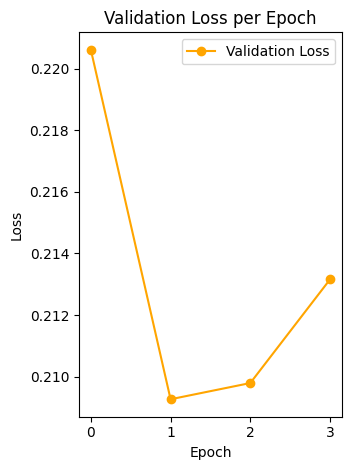

In [ ]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(eval_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

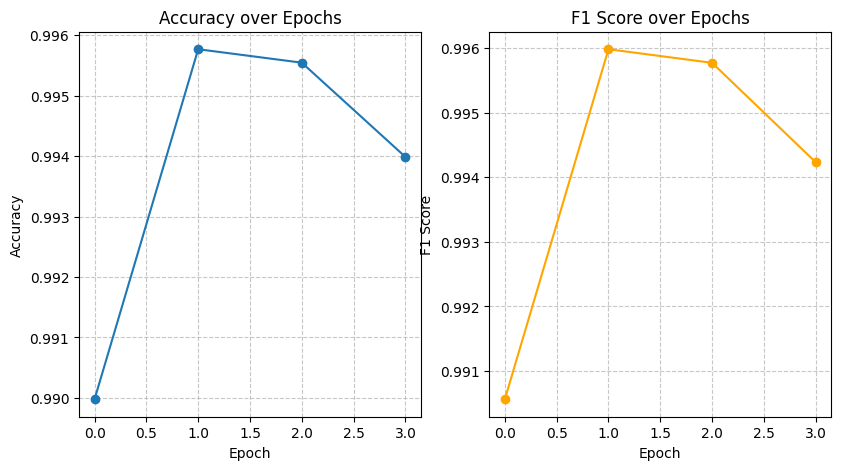

In [ ]:
# Visualize metrics over epochs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot([entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry], marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.plot([entry['eval_f1'] for entry in trainer.state.log_history if 'eval_f1' in entry], marker='o', color='orange')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


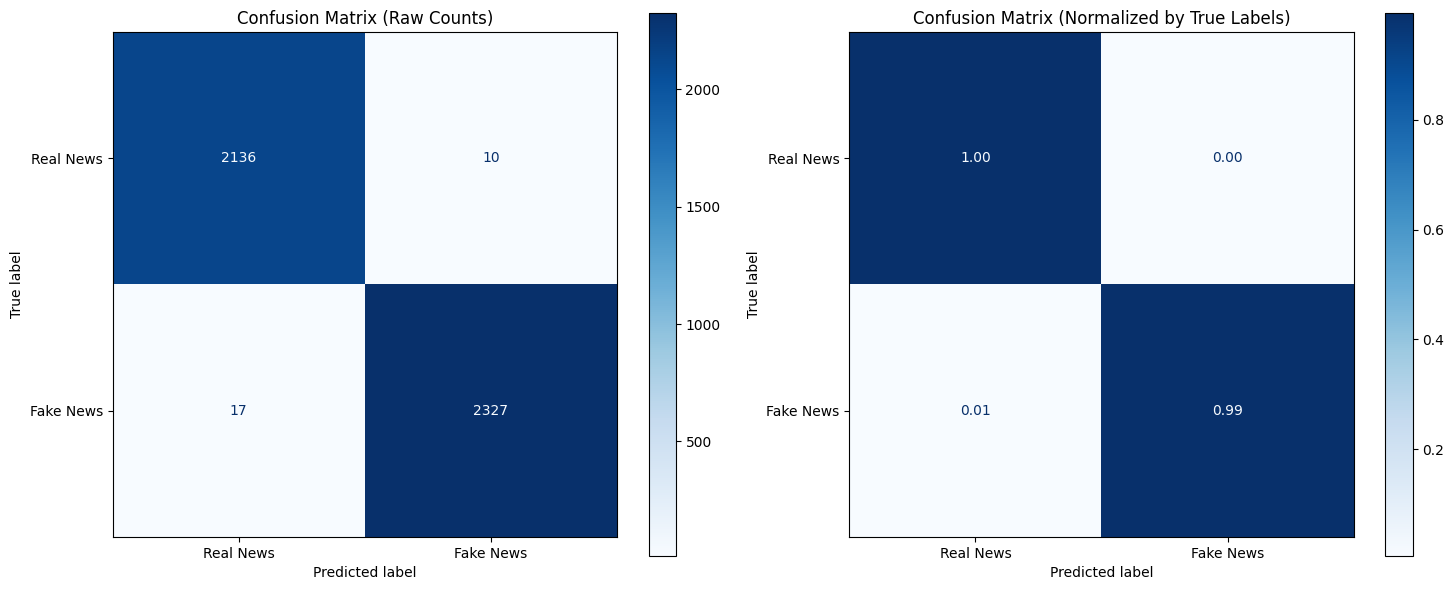

Error Analysis:
True Negatives (correctly identified Real News): 2136 (47.57%)
False Positives (Real News classified as Fake): 10 (0.22%)
False Negatives (Fake News classified as Real): 17 (0.38%)
True Positives (correctly identified Fake News): 2327 (51.83%)
Overall Accuracy: 99.40%
Misclassification Rate: 0.60%


In [ ]:
# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Plot both raw and normalized confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Raw counts
cm = confusion_matrix(y_true, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real News', 'Fake News'])
disp1.plot(ax=ax1, cmap=plt.cm.Blues, values_format='d')
ax1.set_title('Confusion Matrix (Raw Counts)')

# Normalized by true labels (rows)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Real News', 'Fake News'])
disp2.plot(ax=ax2, cmap=plt.cm.Blues, values_format='.2f')
ax2.set_title('Confusion Matrix (Normalized by True Labels)')

plt.tight_layout()
plt.show()

# Calculate and display error rates
tn, fp, fn, tp = cm.ravel()
total = np.sum(cm)

print("Error Analysis:")
print(f"True Negatives (correctly identified Real News): {tn} ({tn/total:.2%})")
print(f"False Positives (Real News classified as Fake): {fp} ({fp/total:.2%})")
print(f"False Negatives (Fake News classified as Real): {fn} ({fn/total:.2%})")
print(f"True Positives (correctly identified Fake News): {tp} ({tp/total:.2%})")
print(f"Overall Accuracy: {(tp+tn)/total:.2%}")
print(f"Misclassification Rate: {(fp+fn)/total:.2%}")

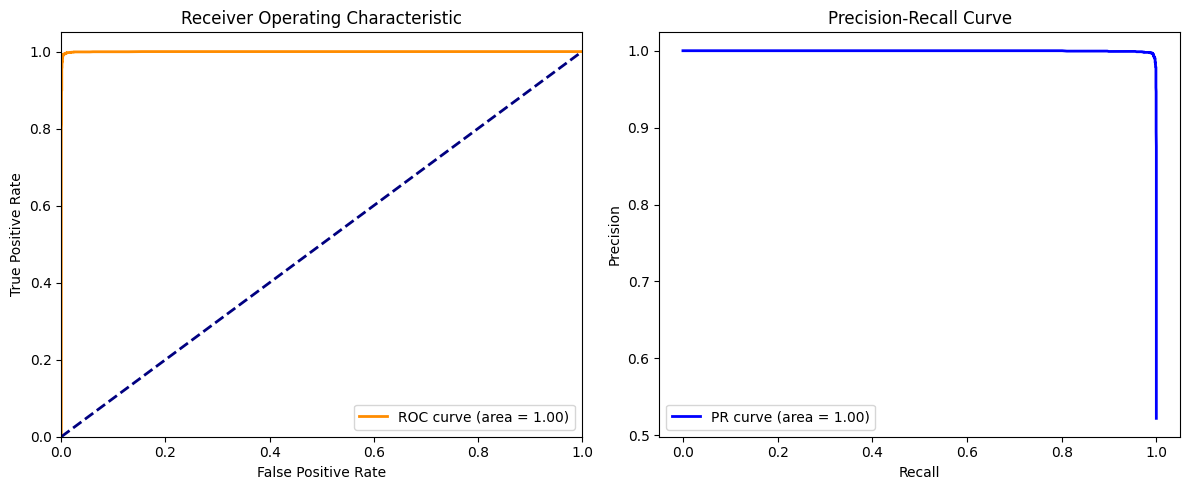

In [ ]:
# Get prediction probabilities
probs = predictions.predictions
y_score = probs[:, 1]  # Probability of class 1 (Fake)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


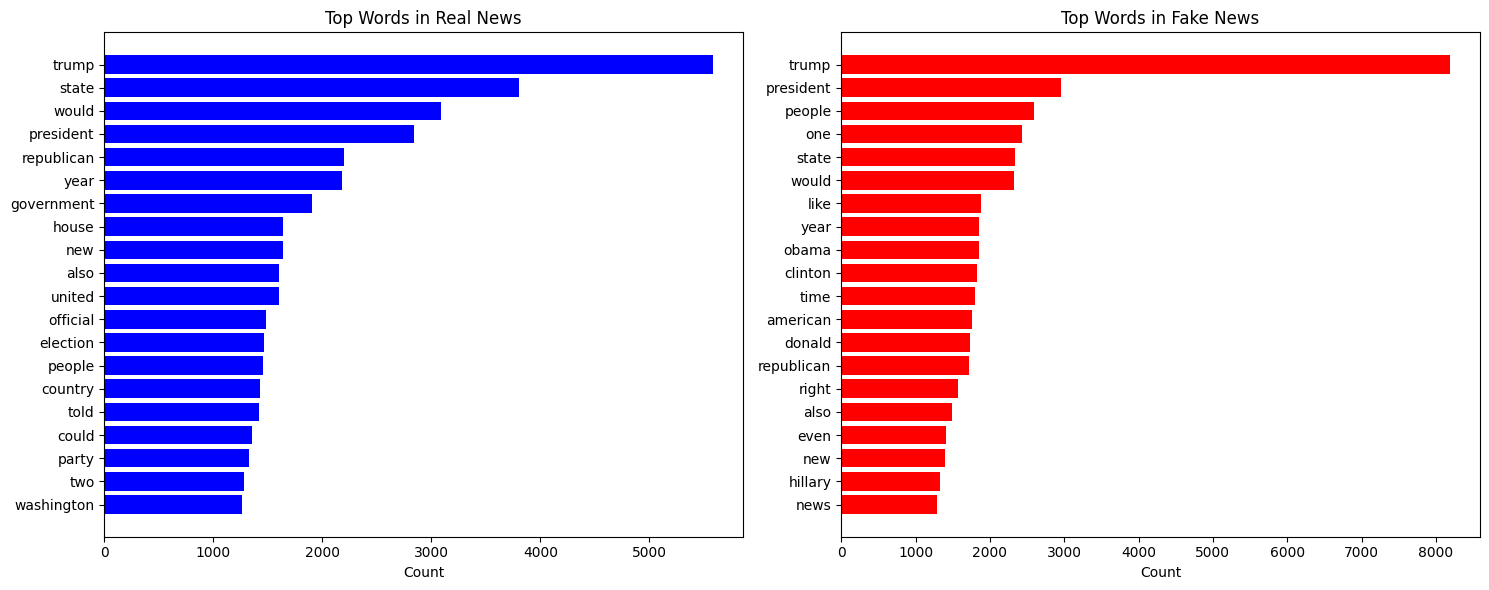

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    words = []
    for text in texts:
        # Convert to lowercase and split
        text_words = re.findall(r'\b\w+\b', text.lower())
        # Remove stopwords
        text_words = [word for word in text_words if word not in stop_words and len(word) > 2]
        words.extend(text_words)

    return Counter(words).most_common(n)

# Get top words for real and fake news
real_top_words = get_top_words([text for text, label in zip(test_texts, test_labels) if label == 0])
fake_top_words = get_top_words([text for text, label in zip(test_texts, test_labels) if label == 1])

# Plot
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh([word for word, count in real_top_words], [count for word, count in real_top_words], color='blue')
plt.title('Top Words in Real News')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh([word for word, count in fake_top_words], [count for word, count in fake_top_words], color='red')
plt.title('Top Words in Fake News')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

Sample text: intelligence law enforcement official warning hacker tie russia intelligence service could try undermine credibility presidential election posting document online purporting show evidence voter fraud official spoke condition anonymity however election system large diffuse antiquated hacker would abl
Prediction: Real with probability 0.948

Explanation:
election: -0.3055
online: -0.2409
could: -0.1857
official: -0.1770
presidential: -0.1725
service: -0.1364
law: -0.1263
however: 0.1160
would: -0.0944
purporting: 0.0921


<Figure size 1000x600 with 0 Axes>

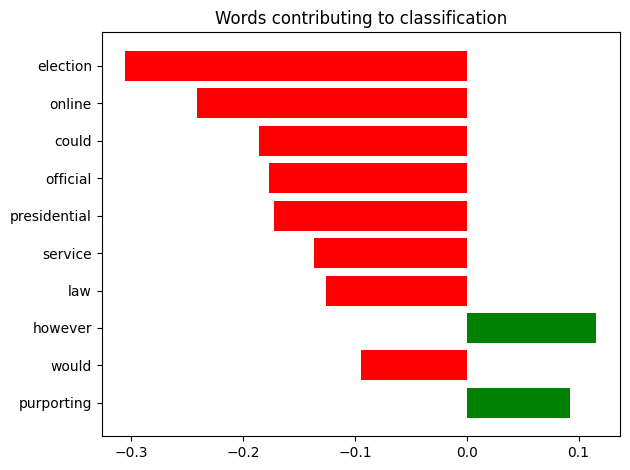

In [ ]:
def explain_prediction(text, model, tokenizer, class_names=['Real', 'Fake']):
    # Create a prediction function for LIME
    def predict_proba(texts):
        results = []
        for t in texts:
            inputs = tokenizer(t, return_tensors="pt", truncation=True, padding=True, max_length=512)
            # Move inputs to the same device as the model
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # Move probs to CPU before converting to numpy
            results.append(probs.cpu().numpy())
        return np.vstack(results)

    # Create the explainer
    explainer = LimeTextExplainer(class_names=class_names)

    # Generate explanation
    exp = explainer.explain_instance(
        text,
        predict_proba,
        num_features=10,
        num_samples=500
    )

    # Display explanation
    print(f"Prediction: {class_names[predict_proba([text])[0].argmax()]} with probability {predict_proba([text])[0].max():.3f}")
    print("\nExplanation:")
    for word, weight in exp.as_list():
        print(f"{word}: {weight:.4f}")

    # Visualize
    fig = plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title("Words contributing to classification")
    plt.tight_layout()
    plt.show()

    return exp

# Try explanation on a sample
sample_text = test_texts[0][:300]  # Take first 300 chars of a test example
print(f"Sample text: {sample_text}")
explanation = explain_prediction(sample_text, model, tokenizer)